In [158]:
%load_ext autoreload
%autoreload 2

from saveload import *
from c_mnist import *
from models import *
from functions import *
from torchvision.datasets import MNIST, FashionMNIST
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
MNIST.name = 'MNIST'
dataset = MNIST
type(dataset.name)

str

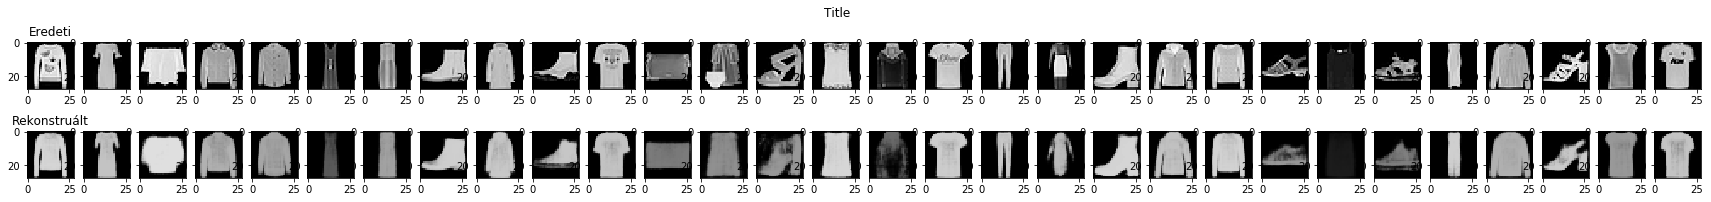

In [165]:
model = load_model(SMVAE_NORMAL, '//mnt/smvae/normal/Normal_SMVAE_60000_0_1_var0.003_seed0.pth')
dataset = create_testset(FashionMNIST, 0.8, 1, return_validation=False)
compare(model, dataset, 30)

In [281]:
#torch.load(ROOT+'evaluation/fashion_logs_seed0_eps0_01.txt')

In [292]:
ROOT = '//mnt/smvae/'
results = torch.load(ROOT+'evaluation/evaluations_fashion_0_eps0_01.txt')

In [293]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df.reindex(sorted(df.index), axis=0)
df = df.rename(columns={0:'ELBO', 1:'REC', 2:'neg_KL'})
df = df[21:]
df = df.round(2)
df

,ELBO,REC,neg_KL
Normal_SMVAE_60000_0.8_1_var0.001_seed0,233.63,275.20,-41.57
Normal_SMVAE_60000_0.8_1_var0.003_seed0,943.01,978.49,-35.49
Normal_SMVAE_60000_0.8_1_var0.01_seed0,879.10,907.21,-28.11
Normal_SMVAE_60000_0.8_1_var0.03_seed0,569.48,590.52,-21.05
Normal_SMVAE_60000_0.8_1_var0.1_seed0,146.87,158.05,-11.18
Normal_SMVAE_60000_0.8_1_var0.3_seed0,-265.33,-258.98,-6.35
Normal_SMVAE_60000_0.8_1_var1_seed0,-728.56,-725.03,-3.52
Normal_SMVAE_60000_0_0.2_var0.001_seed0,-7045.68,-6990.88,-54.81
Normal_SMVAE_60000_0_0.2_var0.003_seed0,-2737.21,-2689.44,-47.77
Normal_SMVAE_60000_0_0.2_var0.01_seed0,-337.15,-294.35,-42.80


In [294]:
def plot_multiple_elbos(df1, df2, c='green'):
    fig, ax = plt.subplots()
    model = 'FashionMNIST_'+ df1.index[0][13:-15]
    labels = [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
    values1 = list(df1['ELBO'])
    values2 = list(df2['ELBO'])
    # Create a line plot
    ax.plot(range(1, 8), values1, marker='o', linestyle=':', color=c, label='Normal')
    ax.plot(range(1, 8), values2, marker='o', linestyle=':', color='orange', label='Standard')
    #ax.plot(range(1, 8), values3, marker='o', linestyle=':')

    plt.grid(axis='y')

    # Set the x-axis labels to the values in x_labels
    ax.set_xticks(range(1, 8))
    ax.set_xticklabels(labels, rotation=45)  # You can adjust the rotation angle as needed

    # Optional: Add labels and a title
    ax.set_xlabel('Observation noise ($\sigma^2$)')
    ax.set_ylabel('ELBO')
    ax.set_title(model)
    ax.legend()

    # Show the plot
    plt.show()

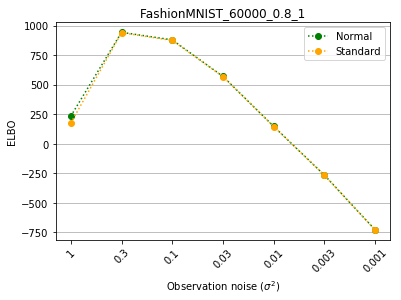

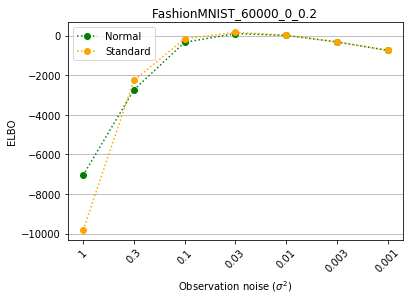

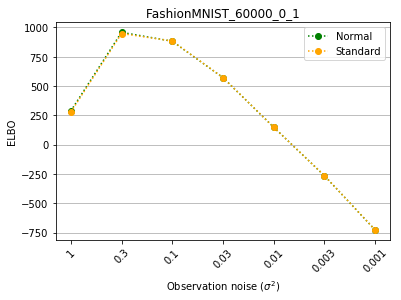

In [295]:
for i in range(3):
    plot_multiple_elbos(df[7*i:7*i+7], df[7*i+21:7*i+28])

In [298]:
def plot_elbos(df, c='blue'):
    fig, ax = plt.subplots()
    model = 'FashionMNIST_' + df.index[0][:-15]
    labels = [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
    values = list(df['ELBO'])
    # Create a line plot
    ax.plot(range(1, 8), values, marker='o', linestyle=':', color=c, label=model)
    #ax.plot(range(1, 8), values2, marker='o', linestyle=':')
    #ax.plot(range(1, 8), values3, marker='o', linestyle=':')

    plt.grid(axis='y')

    # Set the x-axis labels to the values in x_labels
    ax.set_xticks(range(1, 8))
    ax.set_xticklabels(labels, rotation=45)  # You can adjust the rotation angle as needed

    for i, value in enumerate(values):
        ax.text(i + 1, value, str(value), fontsize=10, ha='center', va='bottom')
    
    # Optional: Add labels and a title
    ax.set_xlabel('Observation noise ($\sigma^2$)')
    ax.set_ylabel('ELBO')
    ax.set_title(model)
    #ax.legend()

    # Show the plot
    plt.show()

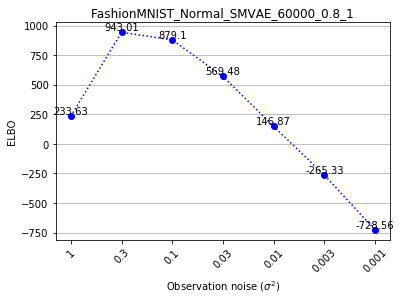

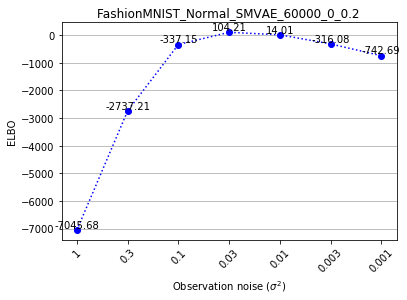

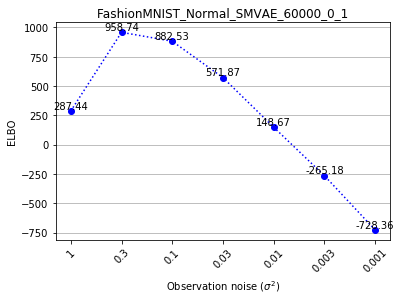

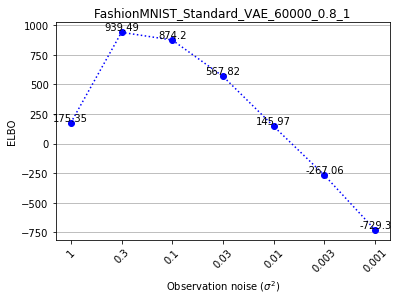

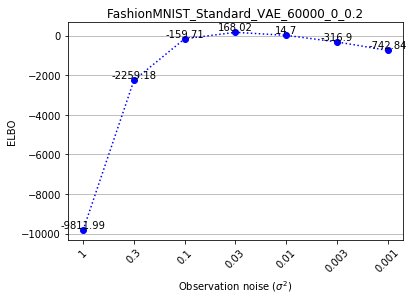

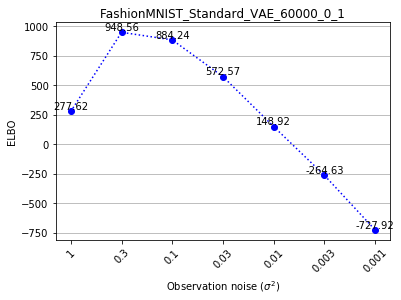

In [299]:
for i in range(6):
    plot_elbos(df[7*i:7*i+7])

In [146]:
l1 = [1, 2, 3]
l2 = [2, 3, 4]
new = []
new.append(l1)
new.append(l2)
new

[[1, 2, 3], [2, 3, 4]]